In [57]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact
import torch

torch.set_grad_enabled(False)

anim_tag = 'human_mv:latest'
anim_tag = 'mv_cat_statue:latest'
anim_tag = 'mv_helmet:latest'

anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
seq = anim.read_anim_seq()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


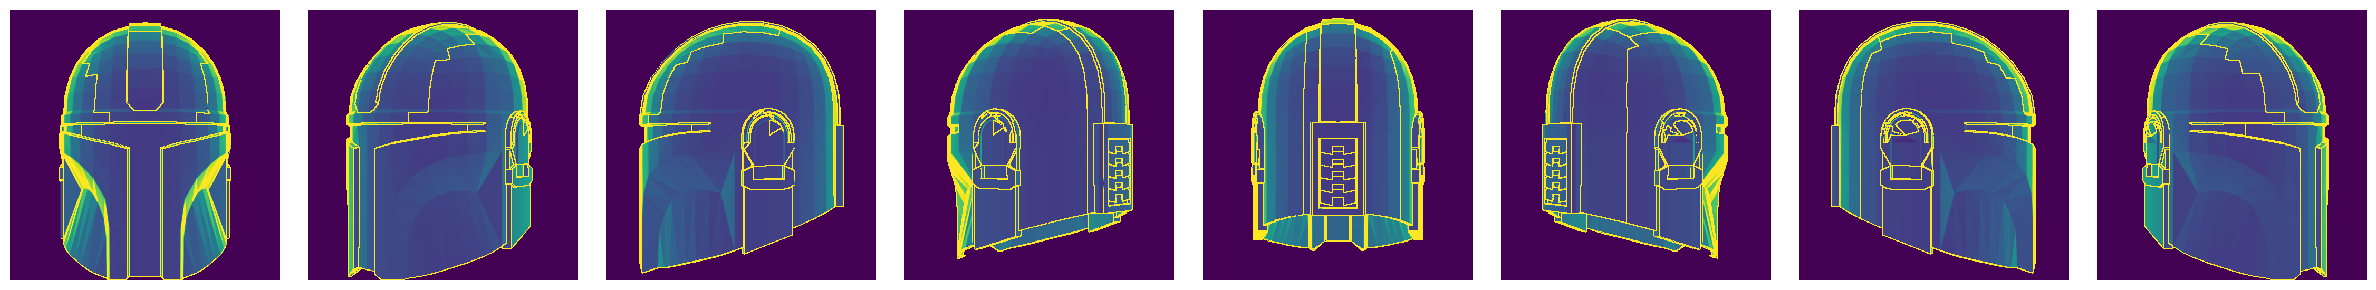

In [58]:
from text3d2video.rendering import compute_uv_jacobian_map
from text3d2video.utilities.ipython_utils import display_ims

quality_maps_uv = torch.stack(
    [
        compute_uv_jacobian_map(c, m, seq.verts_uvs, seq.faces_uvs)
        for c, m in zip(seq.cams, seq.meshes)
    ]
)

display_ims(quality_maps_uv.cpu(), vmin=0, vmax=0.0003)

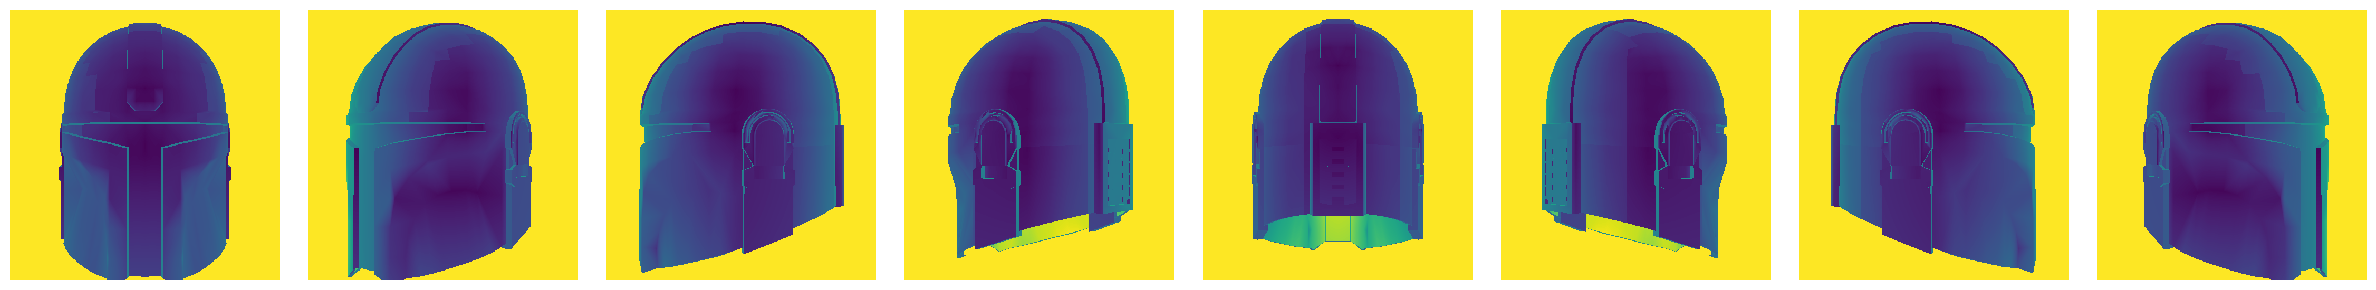

In [59]:
from text3d2video.angle_maps import render_view_angle_map
from text3d2video.utilities.ipython_utils import display_ims
import math

quality_maps_angle = torch.stack(
    [render_view_angle_map(c, m) for c, m in zip(seq.cams, seq.meshes)]
) / math.pi

quality_maps_angle = 1 - quality_maps_angle


display_ims(quality_maps_angle.cpu(), vmin=0, vmax=1)

In [60]:
from text3d2video.backprojection import compute_texel_projections
from text3d2video.rendering import compute_autoregressive_update_masks

uv_res = 500

projections = compute_texel_projections(
    seq.meshes, seq.cams, seq.verts_uvs, seq.faces_uvs, texture_res=uv_res
)

def compute_update_masks(quality_maps):
    return compute_autoregressive_update_masks(
        seq.cams,
        seq.meshes,
        projections,
        quality_maps.cpu(),
        uv_res,
        seq.verts_uvs,
        seq.faces_uvs,
        quality_factor=1.5
    )

update_maps_angle = compute_update_masks(quality_maps_angle)
update_maps_uv = compute_update_masks(quality_maps_uv)

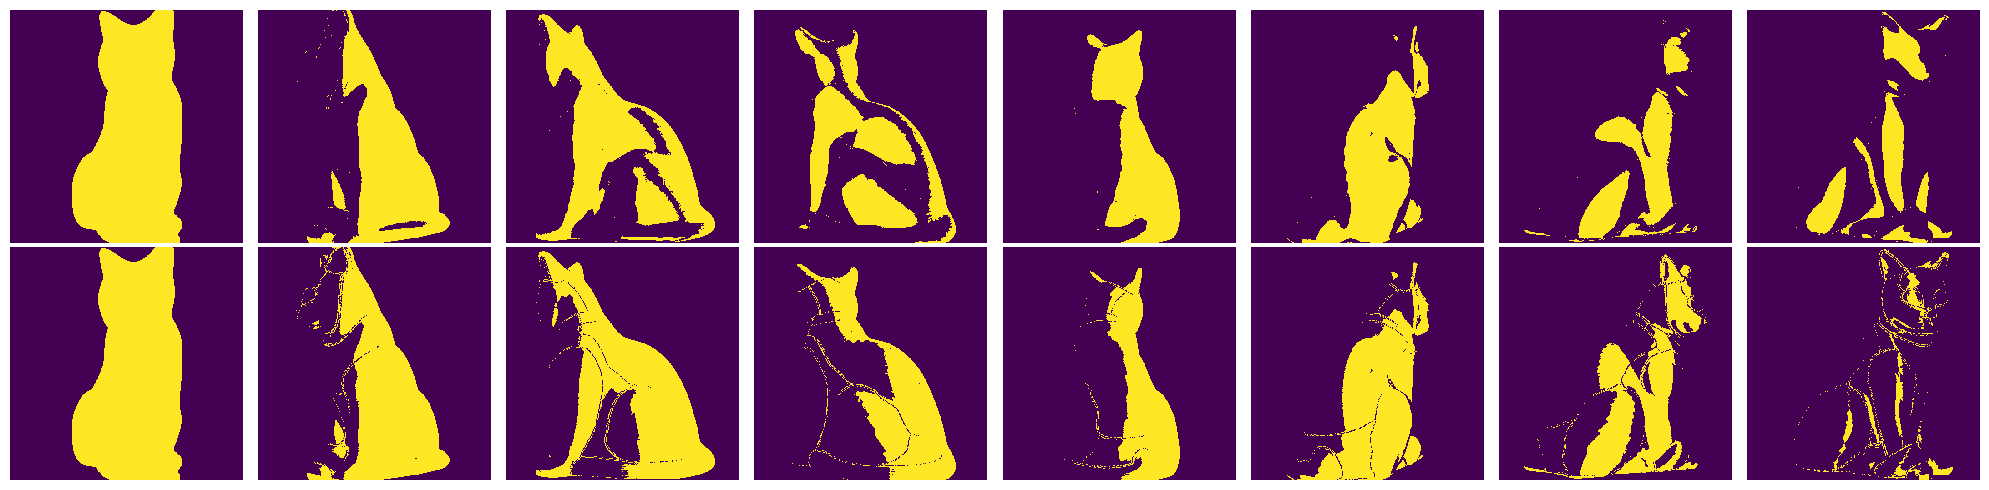

In [56]:
from text3d2video.utilities.ipython_utils import display_ims_grid


display_ims_grid([update_maps_angle, update_maps_uv])

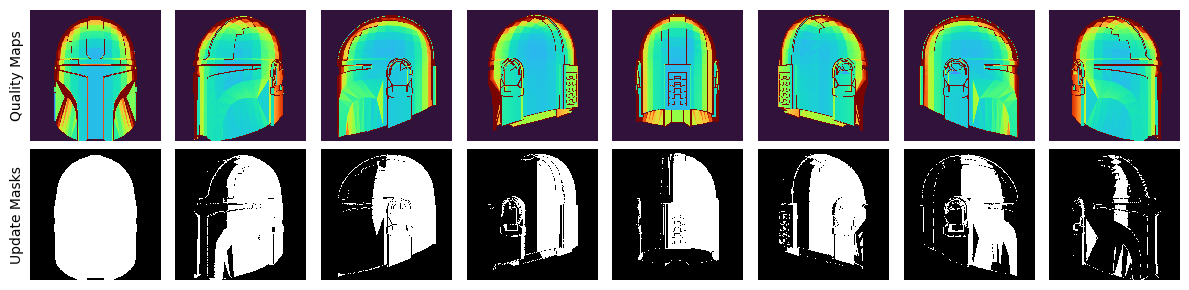

In [ ]:
from matplotlib import pyplot as plt


fig, axs = display_ims_grid(
    [quality_maps_uv, update_maps_uv],
    show=False,
    row_titles=["Quality Maps", "Update Masks"],
    scale=1.5
)

for ax in axs[0, :]:
    im = ax.get_images()[0]
    im.set_clim(0, 0.0002)
    im.set_cmap('turbo')

for ax in axs[1, :]:
    im = ax.get_images()[0]
    im.set_cmap('gray')

plt.savefig('outs/update_masks.pdf', dpi=200)